In [1]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from HRIRDataset import HRIRDataset
from HRIRTransformerModel import HRIRTransformerModel
import matplotlib.pyplot as plt
from CombinedLoss import CombinedLoss

In [2]:
sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
hrir_dataset = HRIRDataset()
for i in range(1,80):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

In [3]:
len(hrir_dataset)

3528

In [4]:
import torch
import torch.nn as nn
from PositionalEncoding import PositionalEncoding

class MyClass(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1, sos_token=-2, eos_token=-3):
        super(MyClass, self).__init__()

        self.sos_token = sos_token
        self.eos_token = eos_token

        self.pos_encoder = PositionalEncoding(d_model)
        
        # Encoder setup
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        
        # Decoder setup
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                        dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        
        # Final linear layer to map decoder output back to d_model (sequence length)
        self.output_layer = nn.Linear(d_model, d_model)  # Adjust as necessary
        
    
    def forward(self, src_with_angle):
        src_with_angle = self.pos_encoder(src_with_angle)
        memory = self.transformer_encoder(src_with_angle)
        dummy_sequence = torch.full_like(src_with_angle, fill_value=self.sos_token)  # Placeholder
        dummy_sequence = self.pos_encoder(dummy_sequence)
        output = self.transformer_decoder(dummy_sequence, memory)

        output = self.output_layer(output)  # Apply final linear layer to map to desired output dimension
        
        return output




In [5]:
import torch.optim as optim
import torch
device = torch.device('cuda')
model = MyClass(d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=4096).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed
loss_function = CombinedLoss(alpha=0.3).to(device) # Lower the alpha value to give more weight to the time
# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


/workspace/venv_work/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

In [7]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [8]:
target_folder = '/workspace/fourth_year_project/HRTF Models/positional_encoding_models/'
# Create it if it doesn't exist
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

In [9]:
def normalize(tensor):
    """
    Normalize a tensor to have values between -1 and 1
    """
    return (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 2 - 1

def add_angle(tensor, angle):
    """
    Add angle to the channel dimension of the tensor
    [batch_size, 1, seq_len] -> [batch_size, 2, seq_len]

    Tensor is shape [32, 1, 512]
    Angle is shape [32]
    Expand angle to match the sequence length [32, 1, 512]
    Concatenate along the channel dimension [32, 2, 512]
    """
    angle_expanded = angle.unsqueeze(-1).unsqueeze(1).expand(-1, 1, tensor.size(2))
    
    # Concatenate the expanded angle tensor with the original tensor along the channel dimension
    tensor_with_angle = torch.cat([tensor, angle_expanded], dim=1)
    
    return tensor_with_angle

def add_sos_and_eos(batch_sequences, sos_value, eos_value):
    """
    Extend each sequence in the batch to include distinct SOS and EOS tokens.
    
    Args:
        batch_sequences (Tensor): Input tensor of shape [batch_size, 2, seq_len].
        sos_value (int or float): The value to use for the SOS token.
        eos_value (int or float): The value to use for the EOS token.
        
    Returns:
        Tensor: Modified batch with SOS at the beginning and EOS at the end, shape [batch_size, 2, seq_len + 2].
    """
    batch_size, channels, seq_len = batch_sequences.shape
    # Create tensors for SOS and EOS tokens for the whole batch
    sos_tokens = torch.full((batch_size, channels, 1), sos_value, dtype=batch_sequences.dtype, device=batch_sequences.device)
    eos_tokens = torch.full((batch_size, channels, 1), eos_value, dtype=batch_sequences.dtype, device=batch_sequences.device)
    
    # Concatenate the SOS token at the beginning and the EOS token at the end
    extended_sequences = torch.cat([sos_tokens, batch_sequences, eos_tokens], dim=-1)
    
    return extended_sequences



def add_sos_and_eos_in_place(batch_sequences, sos_value, eos_value):
    """
    Replace the first and last values in each sequence of the batch with SOS and EOS tokens, respectively,
    keeping the sequence length unchanged.
    
    Args:
        batch_sequences (Tensor): Input tensor of shape [batch_size, 2, seq_len].
        sos_value (int or float): The value to use for the SOS token.
        eos_value (int or float): The value to use for the EOS token.
        
    Returns:
        Tensor: Modified batch with the first and last values replaced by SOS and EOS, respectively,
                shape [batch_size, 2, seq_len].
    """
    # Directly replace the first value of each sequence with the SOS token
    batch_sequences[:, :, 0] = sos_value
    
    # Directly replace the last value of each sequence with the EOS token
    batch_sequences[:, :, -1] = eos_value
    
    return batch_sequences

def preprocess(src, target, angle, device):
    """
    Preprocess the src, target, and angle tensors for training.

    Keeps left channel, adds a channel dimension, converts to float, and normalizes.
    Then adds angle to channel dimension. 
    """
    # Move to the specified device
    src, target, angle = src.to(device), target.to(device), angle.to(device)
    # Select the left channel and add a channel dimension
    src = src[:, 0, :].unsqueeze(1)
    target = target[:, 0, :].unsqueeze(1)
    # Convert to float and normalize
    src = normalize(src.float())
    target = normalize(target.float())
    angle = angle.float()

    src = add_angle(src, angle)
    # target = add_angle(target, angle)

    src = add_sos_and_eos_in_place(src, sos_value=-2, eos_value=-3)
    target = add_sos_and_eos_in_place(target, sos_value=-2, eos_value=-3)

    return src, target

In [10]:


def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for src, target, angle in data_loader:
        # Adjust preprocessing to include shifting the target for teacher forcing
        src, target = preprocess(src, target, angle, device)
        # src - [batch_size, 2, 512], with angle, SOS, EOS
        # taret - [batch_size, 1, 512], with angle, SOS, EOS
        output = model(src)  # Adjust the model's forward method accordingly
        # Only keep the first channel
        output = output[:, 0, :].unsqueeze(1)
        # remove the SOS and EOS tokens from output and target
        output = output[:, :, 1:-1]
        target = target[:, :, 1:-1]
        
        # Compute loss
        # Ensure the loss is calculated against the original target, not the shifted one
        loss = loss_function(output, target)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Update the learning rate
    scheduler.step()
    
    return total_loss / len(data_loader)

def validate_epoch(model, data_loader, loss_function, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for src, target, angle in data_loader:
            src, target = preprocess(src, target, angle, device)
            output = model(src)
            # Only keep the first channel
            output = output[:, 0, :].unsqueeze(1)
            # remove the SOS and EOS tokens from output and target
            output = output[:, :, 1:-1]
            target = target[:, :, 1:-1]
            
            # Compute loss
            loss = loss_function(output, target)
            
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [11]:

num_epochs = 500 # Number of epochs to train for

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1, Train Loss: 9.7548, Validation Loss: 2.1517
Epoch 2, Train Loss: 3.8978, Validation Loss: 1.6974
Epoch 3, Train Loss: 3.9924, Validation Loss: 2.2580
Epoch 4, Train Loss: 3.7515, Validation Loss: 5.3837
Epoch 5, Train Loss: 3.1269, Validation Loss: 1.7920
Epoch 6, Train Loss: 2.8970, Validation Loss: 1.7364
Epoch 7, Train Loss: 2.3268, Validation Loss: 2.1915
Epoch 8, Train Loss: 2.4123, Validation Loss: 3.0814
Epoch 9, Train Loss: 2.9330, Validation Loss: 4.7949
Epoch 10, Train Loss: 2.4796, Validation Loss: 1.4904
Epoch 11, Train Loss: 2.2361, Validation Loss: 1.8453
Epoch 12, Train Loss: 2.1301, Validation Loss: 2.0584
Epoch 13, Train Loss: 2.2862, Validation Loss: 1.8759
Epoch 14, Train Loss: 2.5370, Validation Loss: 1.6830
Epoch 15, Train Loss: 2.1107, Validation Loss: 2.2851
Epoch 16, Train Loss: 2.0584, Validation Loss: 4.1175
Epoch 17, Train Loss: 2.1814, Validation Loss: 2.0736
Epoch 18, Train Loss: 1.8776, Validation Loss: 1.9059
Epoch 19, Train Loss: 1.8648, Validat

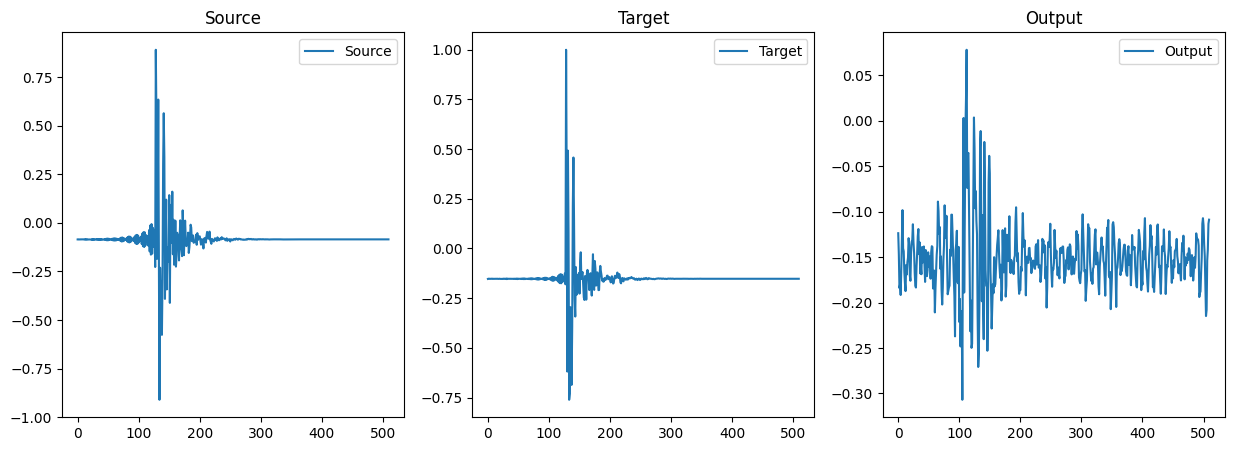

Loss: 1.0320


In [14]:
import matplotlib.pyplot as plt

def test_and_plot(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # No need to track gradients
        # Get one batch from the test_loader
        for src, target, angle in test_loader:
            # Move to the specified device
            src, target = preprocess(src, target, angle, device)
            
            # Forward pass to get the output from the model
            output = model(src)
            # Only keep the first channel
            output = output[:, 0, :].unsqueeze(1)
            # remove the SOS and EOS tokens from output and target
            src = src[:, :, 1:-1]
            output = output[:, :, 1:-1]
            target = target[:, :, 1:-1]
            
            # Plot the first sample in the batch for src, target, and output
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(src[0, 0].cpu().numpy(), label='Source')
            plt.title('Source')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.plot(target[0, 0].cpu().numpy(), label='Target')
            plt.title('Target')
            plt.legend()
            
            plt.subplot(1, 3, 3)
            plt.plot(output[0, 0].cpu().numpy(), label='Output')
            plt.title('Output')
            plt.legend()
            
            plt.show()

            # Print out the loss
            loss = loss_function(output, target)
            print(f'Loss: {loss.item():.4f}')
            
            # Since we only want to plot for the first element, break after the first batch
            break


# Assuming you have a model, test_loader, and device defined
test_and_plot(model, test_loader, device)
